ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
Написать генератор произвольной последовательности рукописных символов.
Сгенерировать набор текстовых строк из допустимых символов.

In [1]:
import os
import random
from PIL import Image
import zipfile
from google.colab import drive

Разрешение на работу с гугл диском

In [2]:
drive.mount('/content/drive')

# Полный путь к вашему архиву на Google Drive.  Замените на ваш путь!
zip_file_path = '/content/drive/My Drive/Носова Светлана/data.zip'

# Проверка существования файла
if os.path.exists(zip_file_path):
    # Распаковка архива
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        extracted_path = '/content/extracted_data' # Указываем папку для распаковки
        os.makedirs(extracted_path, exist_ok=True) # Создаем папку, если её нет
        zip_ref.extractall(extracted_path)

    # Теперь можно обработать распакованные данные
    path_dir = extracted_path
    name = [x[0].split('/')[-1] for x in os.walk(path_dir)][1:] #Обратите внимание на '/'
    if 'times' in name:
        name[name.index('times')] = '*'
    print(name)
else:
    print(f"Ошибка: Файл {zip_file_path} не найден.")



Mounted at /content/drive
['1', 'X', '3', 't', '+', '(', 'h', ',', ')', '*', 'w', '8', '1', '6', '5', '2', '4', '7', '-', '9', '0', 'y']


In [3]:
def random_strings(char_list, string_length, num_strings):
    result = []
    random.seed(0)
    for _ in range(num_strings):
        random_string = ''.join(random.choice(char_list) for _ in range(string_length))
        result.append(random_string)
    return result

char_list = name
strings = random_strings(char_list, string_length=5, num_strings=10)
print(strings)

['16X)4', '21*28', '-h4+*', '+t9)7', '9+*t3', 'yw27t', '86w90', 'h7254', ')X713', '1y019']


Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

In [4]:
def get_image_paths_for_strings(strings, root_dir):
    image_paths = {}

    for s in strings:
        image_paths[s] = []
        for char in s:
            if char == '*': char = 'times'
            folder_path = os.path.join(root_dir, char)
            if os.path.exists(folder_path):
                images = os.listdir(folder_path)
                if images:
                    chosen_image = random.choice(images)
                    full_image_path = os.path.join(folder_path, chosen_image)
                    image_paths[s].append(full_image_path)

    return image_paths

In [5]:
def create_combined_image(symbol_paths, output_path, img_size=(45, 45), padding=15, border=10):
    total_width = img_size[0] * len(symbol_paths) + padding * (len(symbol_paths) - 1) + 2 * border
    total_height = img_size[1] + 2 * border

    combined_image = Image.new("RGB", (total_width, total_height), color=(255, 255, 255))

    x_offset = border
    for path in symbol_paths:
        symbol_img = Image.open(path)
        combined_image.paste(symbol_img, (x_offset, border))
        x_offset += img_size[0] + padding

    combined_image.save(output_path)
    print(f"Изображение сохранено в дирректории: {output_path}")

In [6]:
result = get_image_paths_for_strings(strings, path_dir)
my_images_paths = {}

for string, paths in result.items():
    _string = string.replace('*', '[times]')
    create_combined_image(paths, f"out\{_string}_image.png")
    my_images_paths[string] = f"out\{_string}_image.png"

Изображение сохранено в дирректории: out\16X)4_image.png
Изображение сохранено в дирректории: out\21[times]28_image.png
Изображение сохранено в дирректории: out\-h4+[times]_image.png
Изображение сохранено в дирректории: out\+t9)7_image.png
Изображение сохранено в дирректории: out\9+[times]t3_image.png
Изображение сохранено в дирректории: out\yw27t_image.png
Изображение сохранено в дирректории: out\86w90_image.png
Изображение сохранено в дирректории: out\h7254_image.png
Изображение сохранено в дирректории: out\)X713_image.png
Изображение сохранено в дирректории: out\1y019_image.png


**КЛАССИФИКАЦИЯ**

Часть символов оставить для обучения классификатора . Остальные классифицировать по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
Выбрать оптимальный классификатор в зависимости от k- количество соседей.
Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [7]:
import cv2
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [8]:
def get_cv_image(image):
    # если дан путь к изображению
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # если дано изобажение PIL
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (45, 45)).flatten()

    return None

In [9]:
x = []
y = []

def process_label_images(label, img_paths):
    vectors = [get_vector(path) for path in img_paths]
    labels = [label] * len(vectors)
    return vectors, labels

with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda item: process_label_images(*item), result.items()))

for vectors, labels in results:
    x.extend(vectors)
    y.extend(labels)

x = np.array(x, dtype=np.float32)
y = y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

param_grid = {'n_neighbors': range(1, 11)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Лучшее значение k: {best_k}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Лучшее значение k: 10


In [12]:
def create_and_write_model(path_file, k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)
    with open(path_file, 'wb') as file:
        pickle.dump(knn_model, file)

def read_model(path_file):
    with open(path_file, 'rb') as file:
        knn_model_loaded = pickle.load(file)
    return knn_model_loaded



In [13]:
model_path = 'knn_model.pkl'

create_and_write_model(model_path, best_k)
knn_model = read_model(model_path)
predictions = knn_model.predict(x_test)

print(f'accuracy = {accuracy_score(y_test, predictions)}')

accuracy = 0.0


In [14]:
import matplotlib.pyplot as plt

def merge_two_rects(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def calculate_distance(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

def merge_close_rectangles(rects, distance_threshold, count_limit):
    while len(rects) > count_limit:
        pairs_to_merge = [
            (rects[i], rects[j])
            for i in range(len(rects))
            for j in range(i + 1, len(rects))
            if calculate_distance(rects[i], rects[j]) < distance_threshold
        ]

        if not pairs_to_merge: break  # Если нет пар для объединения, выходим из цикла

        rect1, rect2 = pairs_to_merge[0]
        merged_rect = merge_two_rects(rect1, rect2)
        rects.remove(rect1)
        rects.remove(rect2)
        rects.append(merged_rect)

    return rects

def merge_rectangles(rects, distance_threshold = 25, count_limit = 10):
    rects = merge_close_rectangles(rects, distance_threshold, count_limit)

    if len(rects) > count_limit:
        rects = sorted(rects, key=lambda rect: (rect[2] * rect[3]), reverse=True)
        big_rects = rects[:count_limit]
        other_rects = rects[count_limit:]

        for rect in other_rects:
            closest_big_rect = min(big_rects, key=lambda big: calculate_distance(rect, big))
            merged_rect = merge_two_rects(rect, closest_big_rect)
            big_rects[big_rects.index(closest_big_rect)] = merged_rect

        return big_rects

    return rects

def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]

    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    if len(rects) > 10:
        rects = merge_rectangles(rects)

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]

    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return symbols

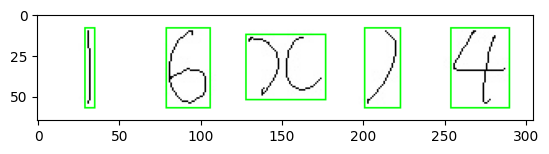

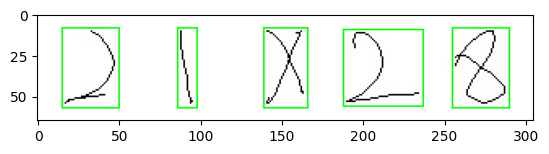

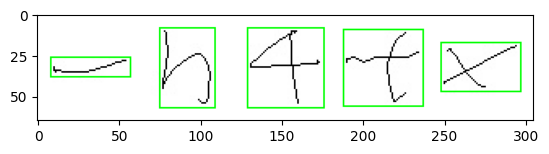

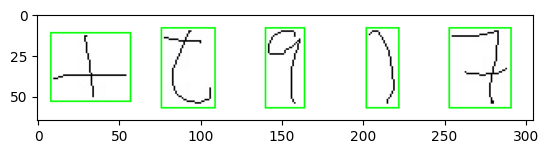

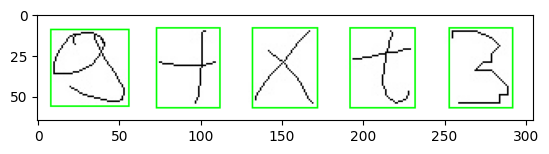

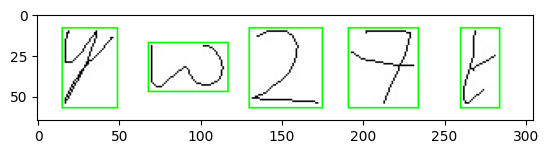

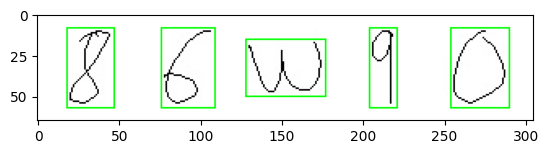

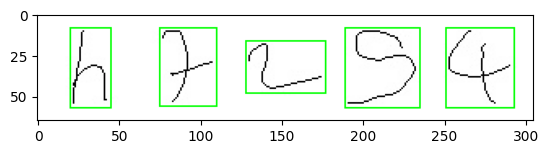

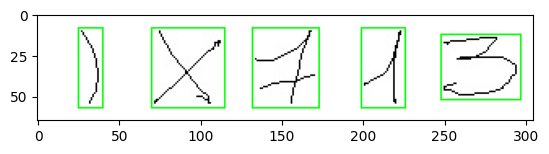

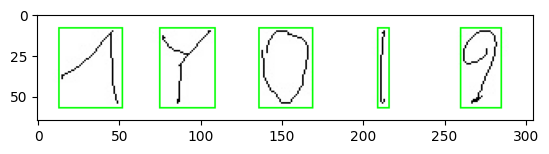

In [15]:
results = []
symb_vectors = []

for string, img_path in my_images_paths.items():
    symb_images = extract_symbols(img_path)
    predictions = knn_model.predict(symb_images)
    accuracy = accuracy_score(list(string), list(predictions[0]))
    results.append((string, predictions[0], accuracy))

In [16]:
from pandas import DataFrame, concat

df_results = DataFrame(results, columns=['Исходные символы', 'Предсказанные символы', 'Accuracy'])
mean_accuracy = df_results['Accuracy'].mean()

new_row = DataFrame({
    'Символы исходной строки': [''],
    'Предсказанные символы': ['Средняя accuracy'],
    'Accuracy': [mean_accuracy]
})

df_result = concat([df_results, new_row], ignore_index=True)
df_result

,Исходные символы,Предсказанные символы,Accuracy,Символы исходной строки
0,16X)4,)X713,0.0,NaN
1,21*28,16X)4,0.0,NaN
2,-h4+*,21*28,0.0,NaN
3,+t9)7,9+*t3,0.0,NaN
4,9+*t3,9+*t3,1.0,NaN
5,yw27t,9+*t3,0.0,NaN
6,86w90,9+*t3,0.0,NaN
7,h7254,h7254,1.0,NaN
8,)X713,+t9)7,0.0,NaN
9,1y019,9+*t3,0.0,NaN


**Рассчет CER**

In [18]:
import editdistance

def modify_and_calculate_cer(row):
    original = list(row['Исходные символы'])
    predicted = list(row['Предсказанные символы'])

    num_to_modify = random.randint(1, 3)
    indices = random.sample(range(len(predicted)), num_to_modify)
    predicted = [predicted[i] for i in range(len(predicted)) if i not in indices]
    symbols = [x[0].split('\\')[-1] for x in os.walk(path_dir)][1:]
    predicted += random.choices(symbols, k=num_to_modify)

    cer = editdistance.eval(''.join(original), ''.join(predicted)) / max(len(original), len(predicted) or 1)
    return ''.join(original), ''.join(predicted), cer



In [19]:
df_results[['Исходные символы', 'Предсказанные символы', 'CER']] = df_results.apply(modify_and_calculate_cer, axis=1, result_type='expand')

mean_cer = df_results['CER'].mean()

new_row = DataFrame({
    'Исходные символы': [''],
    'Предсказанные символы': ['Среднее значение'],
    'CER': [mean_cer]
})

df_сer = concat([df_results, new_row], ignore_index=True).drop(columns=['Accuracy'])
df_сer

,Исходные символы,Предсказанные символы,CER
0,16X)4,71/content/extracted_data/-/content/extracted_...,15.20
1,21*28,16/content/extracted_data/7/content/extracted_...,15.40
2,-h4+*,28/content/extracted_data/w/content/extracted_...,15.40
3,+t9)7,+t3/content/extracted_data/6/content/extracted...,10.20
4,9+*t3,t3/content/extracted_data/1/content/extracted_...,15.20
5,yw27t,9t3/content/extracted_data/times/content/extra...,11.20
6,86w90,9*t3/content/extracted_data/1,5.80
7,h7254,72/content/extracted_data/3/content/extracted_...,15.20
8,)X713,+t97/content/extracted_data/3,5.40
9,1y019,+*t3/content/extracted_data/6,5.80
